In [51]:
# 필요한 라이브러리 설치 (필요한 경우)
# !pip install h2o shap lime pandas scikit-learn matplotlib

import h2o
from h2o.automl import H2OAutoML
import shap
import lime
import lime.lime_tabular
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import warnings
warnings.filterwarnings('ignore')
# H2O 초기화
h2o.init()

# SHAP 시각화를 위한 초기 설정 (Jupyter Notebook/Lab 환경)
shap.initjs()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "21" 2023-09-19; OpenJDK Runtime Environment (build 21+35-2513); OpenJDK 64-Bit Server VM (build 21+35-2513, mixed mode, sharing)
  Starting server from /Users/dante/workspace/dante-code/projects/kmu-practical-ds-2025/.conda/lib/python3.12/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/5y/vwfpdbc96lb5kxd7pmfd9rl00000gn/T/tmpy0bxat9q
  JVM stdout: /var/folders/5y/vwfpdbc96lb5kxd7pmfd9rl00000gn/T/tmpy0bxat9q/h2o_dante_started_from_python.out
  JVM stderr: /var/folders/5y/vwfpdbc96lb5kxd7pmfd9rl00000gn/T/tmpy0bxat9q/h2o_dante_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_dante_4dvgfp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.984 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


### 데이터 준비

In [3]:
# 데이터 로드 (H2O 제공 와인 품질 데이터셋 예시)
data_path = "https://h2o-public-test-data.s3.amazonaws.com/smalldata/wine/winequality-redwhite-no-BOM.csv"
df_h2o = h2o.import_file(data_path)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
df_h2o

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6,white
6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6,white
8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6,white
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6,white
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6,white
8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6,white
6.2,0.32,0.16,7,0.045,30,136,0.9949,3.18,0.47,9.6,6,white
7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6,white
6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6,white
8.1,0.22,0.43,1.5,0.044,28,129,0.9938,3.22,0.45,11,6,white


In [5]:
type(df_h2o)

h2o.frame.H2OFrame

In [6]:
# Pandas DataFrame으로도 변환 (SHAP/LIME 사용 시 필요)
df_pd = df_h2o.as_data_frame()
df_pd.head()

/Users/dante/workspace/dante-code/projects/kmu-practical-ds-2025/.conda/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


In [7]:
# 특성(X)과 타겟(y) 변수 설정
response_column = "quality" # 예측 대상 컬럼 (와인 품질)
# 나머지 컬럼을 특성으로 사용
predictors = df_h2o.columns
predictors.remove(response_column)

In [13]:
# H2O Frame을 훈련/테스트 데이터로 분할
train_h2o, test_h2o = df_h2o.split_frame(ratios=[0.8], seed=1)

# Pandas DataFrame도 동일하게 분할 (XAI 라이브러리 사용 시 필요)
train_pd = train_h2o.as_data_frame()
test_pd = test_h2o.as_data_frame()

X_train_pd = train_pd[predictors]
y_train_pd = train_pd[response_column]
X_test_pd = test_pd[predictors]
y_test_pd = test_pd[response_column]

print("훈련 데이터 크기:", train_h2o.shape)
print("테스트 데이터 크기:", test_h2o.shape)


훈련 데이터 크기: (5205, 13)
테스트 데이터 크기: (1292, 13)


/Users/dante/workspace/dante-code/projects/kmu-practical-ds-2025/.conda/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/dante/workspace/dante-code/projects/kmu-practical-ds-2025/.conda/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


### H2O AutoML 실행

In [14]:
# H2O AutoML 설정
aml = H2OAutoML(max_runtime_secs=120,  # 최대 실행 시간 (초)
                seed=1)             # 재현성을 위한 시드

In [15]:
# AutoML 학습 시작
print("H2O AutoML 학습 시작...")
start_time = time.time()
aml.train(x=predictors, y=response_column, training_frame=train_h2o)
end_time = time.time()
print(f"AutoML 학습 완료. 소요 시간: {end_time - start_time:.2f} 초")


H2O AutoML 학습 시작...
AutoML progress: |
10:37:48.554: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
AutoML 학습 완료. 소요 시간: 121.85 초


In [16]:
# AutoML 결과 확인 (리더보드)
lb = aml.leaderboard
print("\\nAutoML 리더보드:")
print(lb.head(rows=lb.nrows)) # 모든 모델 결과 보기

\nAutoML 리더보드:
model_id                                                              rmse       mse       mae        rmsle    mean_residual_deviance
StackedEnsemble_AllModels_4_AutoML_1_20250419_103748              0.608024  0.369693  0.429504    0.0921405                  0.369693
StackedEnsemble_AllModels_3_AutoML_1_20250419_103748              0.608196  0.369903  0.429794    0.0921692                  0.369903
StackedEnsemble_BestOfFamily_4_AutoML_1_20250419_103748           0.610222  0.372371  0.433218    0.0924626                  0.372371
StackedEnsemble_BestOfFamily_3_AutoML_1_20250419_103748           0.613824  0.37678   0.43937     0.0929672                  0.37678
StackedEnsemble_AllModels_2_AutoML_1_20250419_103748              0.613843  0.376804  0.439252    0.0929623                  0.376804
StackedEnsemble_BestOfFamily_2_AutoML_1_20250419_103748           0.614111  0.377132  0.440676    0.0929908                  0.377132
StackedEnsemble_AllModels_1_AutoML_1_20250419_10

### AutoML 결과 분석

> **📊 분석 요약**
> 
> **최고 성능 모델**
> - **최우수 모델**: "StackedEnsemble_AllModels_4_AutoML_1_20250419_103748"
> - **성능**: RMSE 0.608024로 1위
> - **앙상블 우세**: 상위 10개 모델 중 7개가 스택 앙상블 모델
> 
> **모델 유형별 성능 순위**
> 1. 스택 앙상블(StackedEnsemble)
> 2. GBM/DRF/XRT
> 3. DeepLearning
> 4. GLM
> 
> **성능 분포 특징**
> - GBM 모델들: 중간 성능대에 다수 분포
> - 딥러닝 모델들: 대체로 하위권에 위치
> 
> **오차 지표 분석**
> - **최상위 모델**: RMSE: 0.608055, MSE: 0.369731, MAE: 0.42982
> - **최하위 모델**: RMSE 0.889345 (최상위보다 46% 더 높음)
> - **RMSLE 분포**: 대부분 0.09~0.12 범위
> 
> **결론**
> 앙상블 모델이 단일 모델보다 일관되게 우수한 성능을 보여주며, 특히 GBM 기반 모델들이 전체적으로 좋은 예측력을 나타냄

In [17]:
# 최적 모델 (리더 모델) 확인
leader_model = aml.leader
print("최적 모델 (Leader Model):")
print(leader_model.model_id)

최적 모델 (Leader Model):
StackedEnsemble_AllModels_4_AutoML_1_20250419_103748


### XAI : H2O 내장 설명 기능 활용

In [18]:
print(test_h2o)

  fixed acidity    volatile acidity    citric acid    residual sugar    chlorides    free sulfur dioxide    total sulfur dioxide    density    pH    sulphates    alcohol    quality  type
            8.1                0.28           0.4               6.9         0.05                      30                      97     0.9951  3.26         0.44       10.1          6  white
            8.1                0.22           0.43              1.5         0.044                     28                     129     0.9938  3.22         0.45       11            6  white
            6.2                0.66           0.48              1.2         0.029                     29                      75     0.9892  3.33         0.39       12.8          8  white
            7                  0.33           0.32              1.2         0.053                     38                     138     0.9906  3.13         0.28       11.2          6  white
            7.3                0.24           0.39           

--- H2O AutoML 전체 설명 ---


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_3_AutoML_1_20250419_103748,0.572987,0.328314,0.396822,0.086705,0.328314,447,0.053416,StackedEnsemble
StackedEnsemble_AllModels_4_AutoML_1_20250419_103748,0.572987,0.328314,0.396822,0.086705,0.328314,239,0.054849,StackedEnsemble
GBM_grid_1_AutoML_1_20250419_103748_model_21,0.574901,0.330511,0.402227,0.0864859,0.330511,315,0.005446,GBM
StackedEnsemble_BestOfFamily_4_AutoML_1_20250419_103748,0.575362,0.331042,0.400761,0.0870463,0.331042,246,0.008305,StackedEnsemble
GBM_grid_1_AutoML_1_20250419_103748_model_47,0.576363,0.332195,0.403384,0.0872868,0.332195,333,0.002993,GBM
StackedEnsemble_AllModels_2_AutoML_1_20250419_103748,0.578901,0.335126,0.408036,0.0875099,0.335126,143,0.012166,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20250419_103748,0.578901,0.335126,0.408036,0.0875099,0.335126,137,0.011356,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20250419_103748,0.579385,0.335687,0.409849,0.0875691,0.335687,139,0.008319,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20250419_103748,0.579385,0.335687,0.409849,0.0875691,0.335687,142,0.008763,StackedEnsemble
XRT_1_AutoML_1_20250419_103748,0.580639,0.337142,0.419324,0.0876339,0.337142,416,0.002561,DRF


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

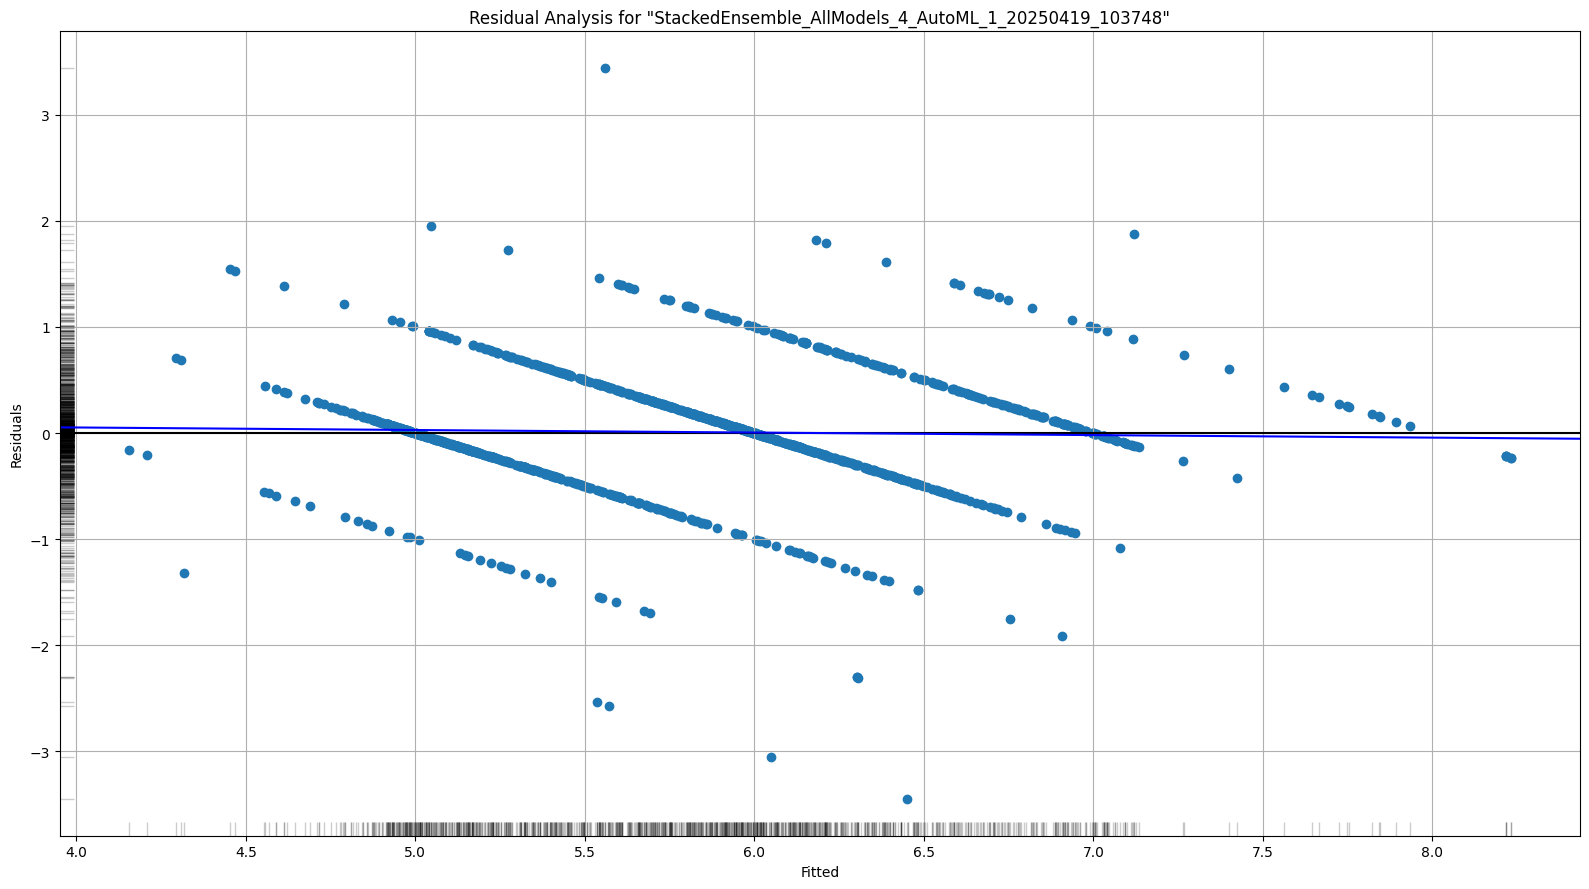

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

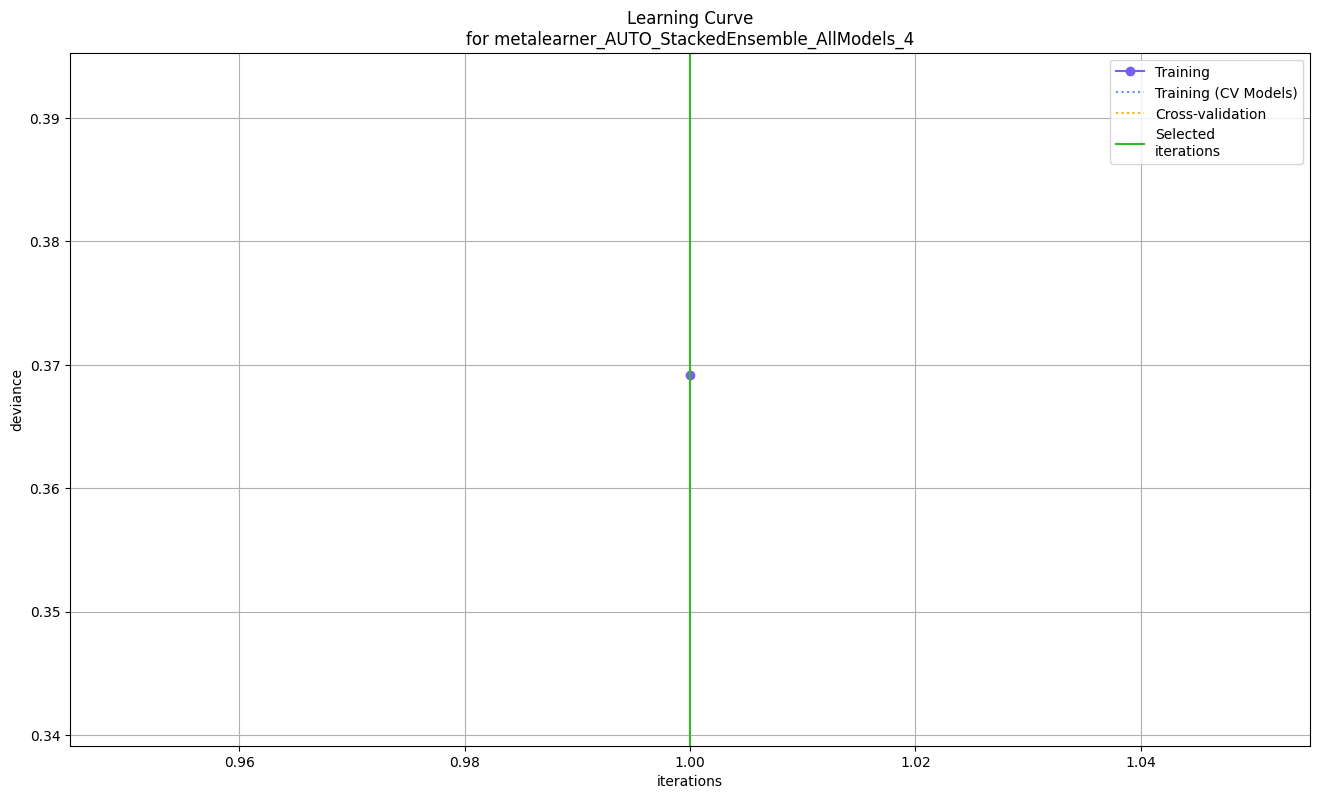

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

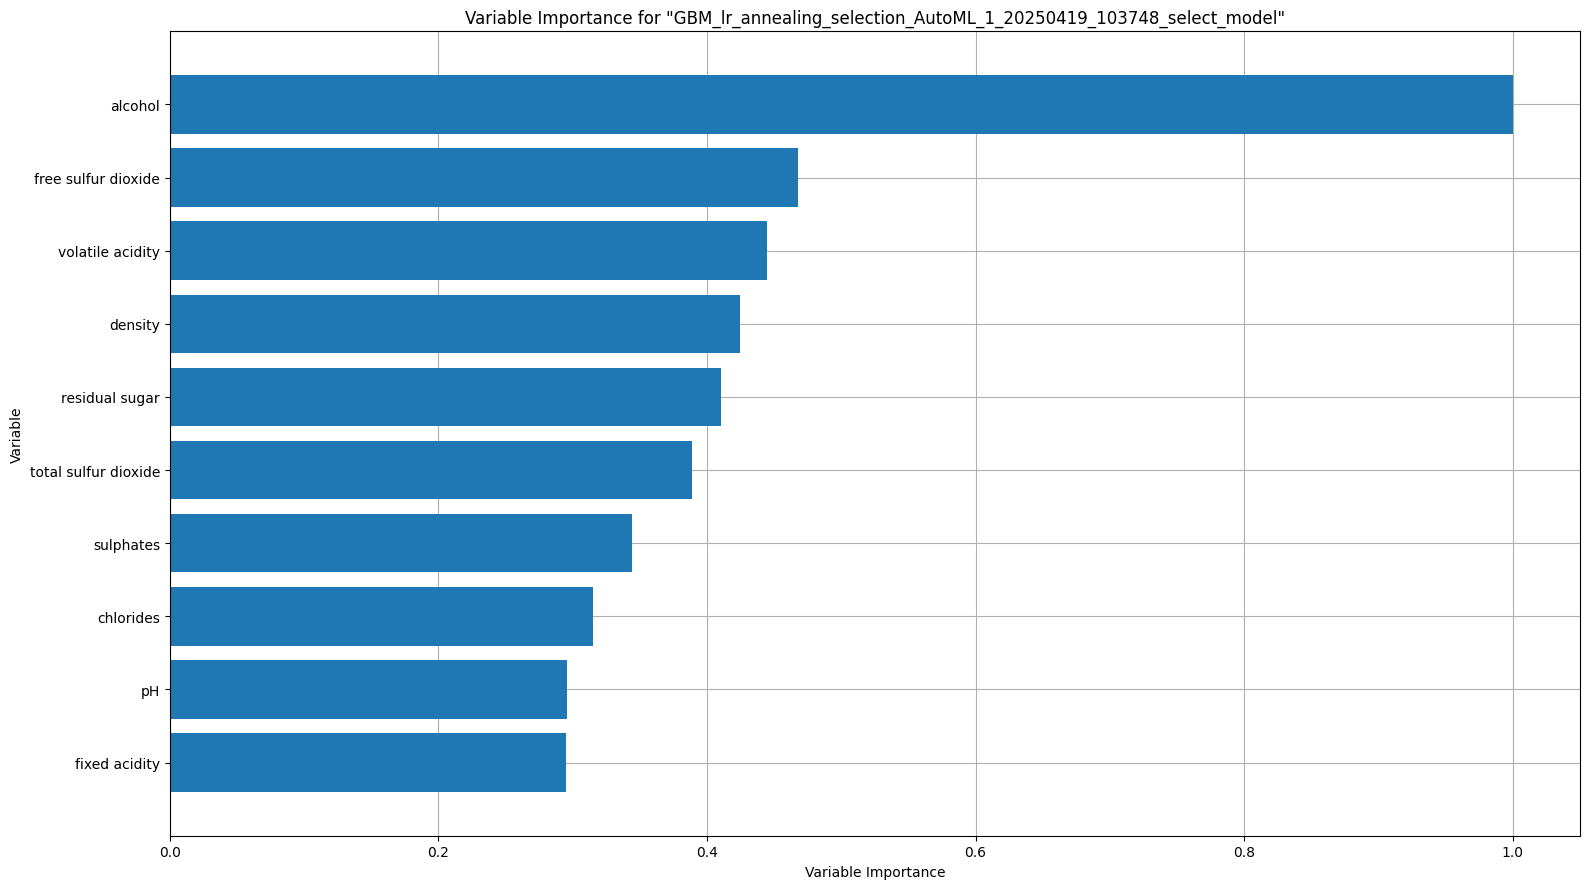

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

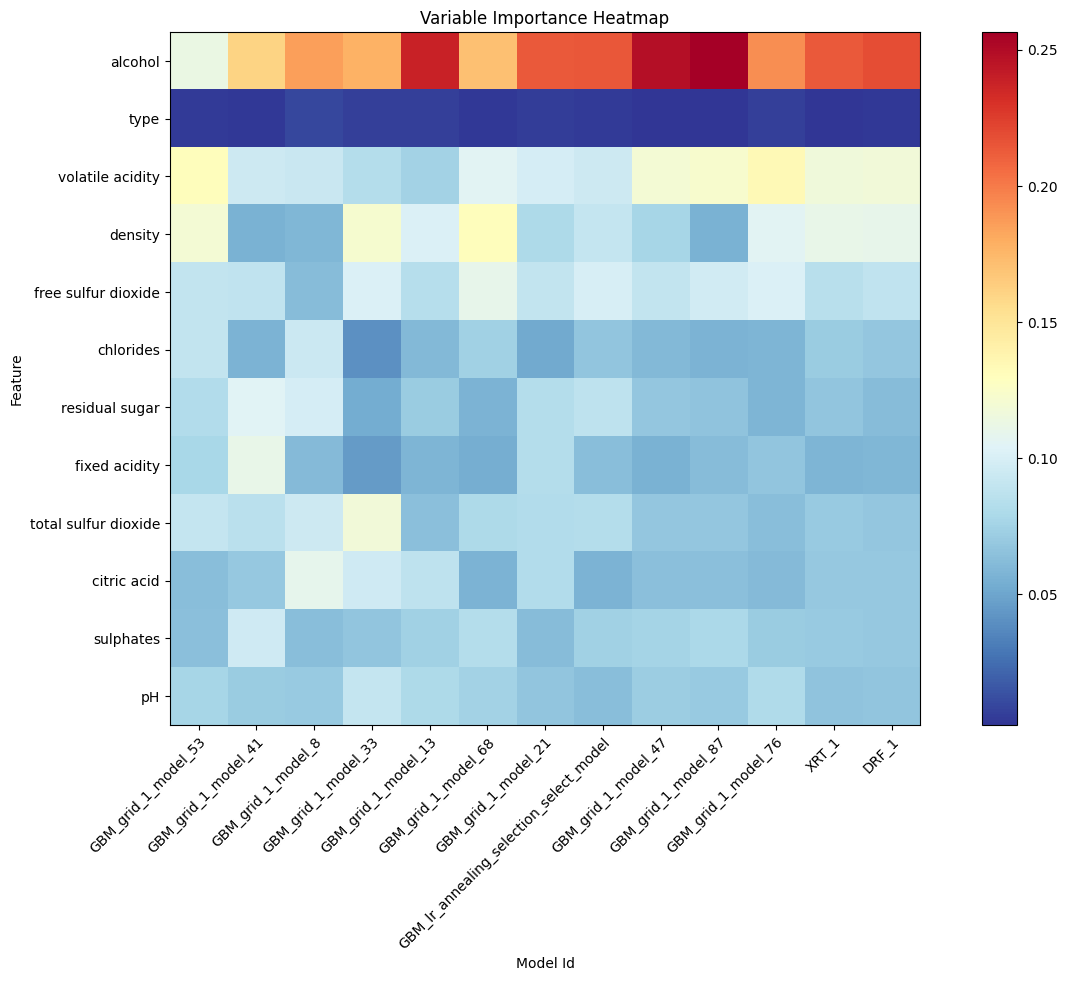

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

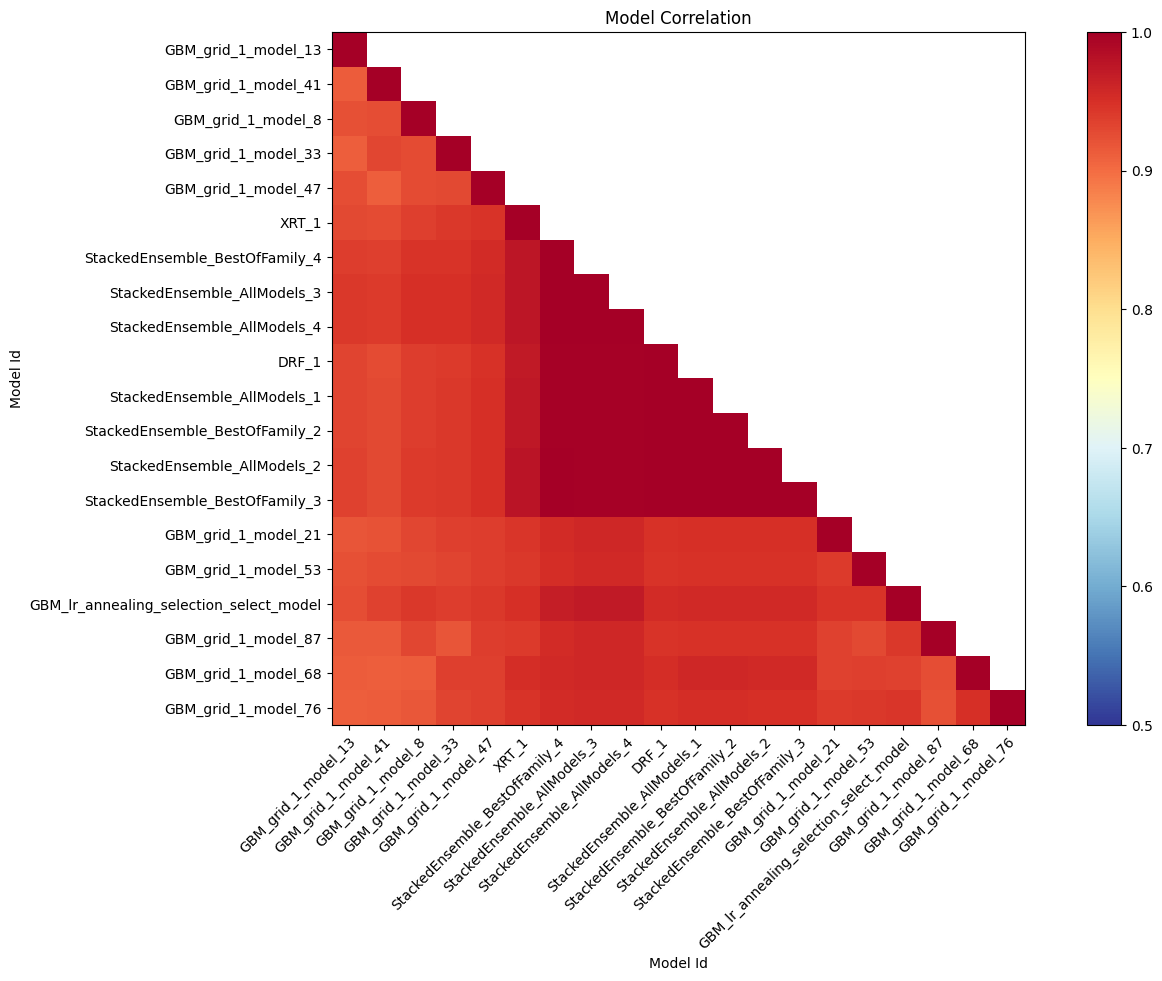

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

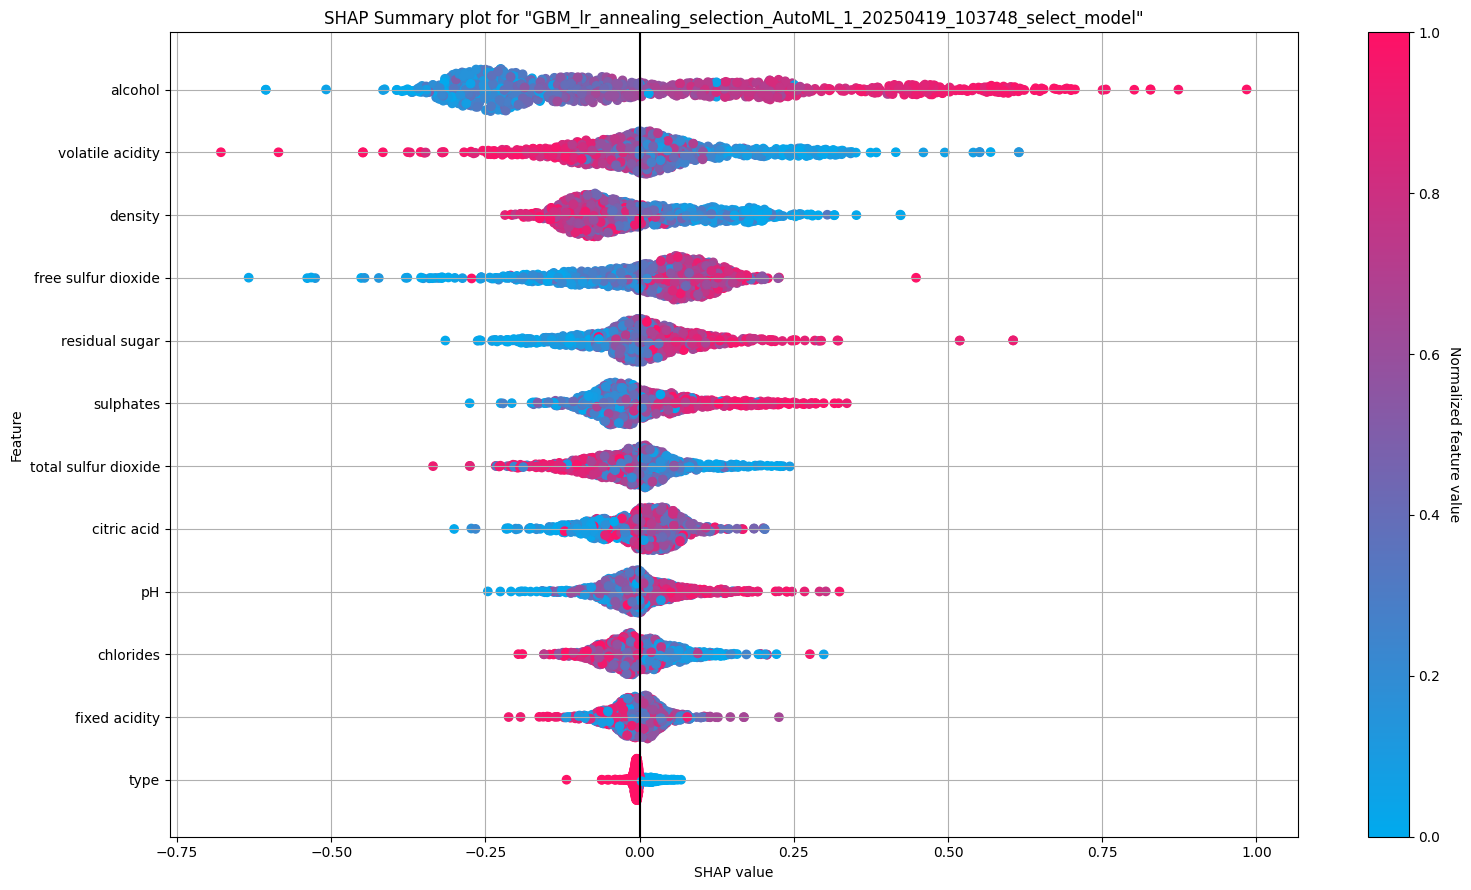

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

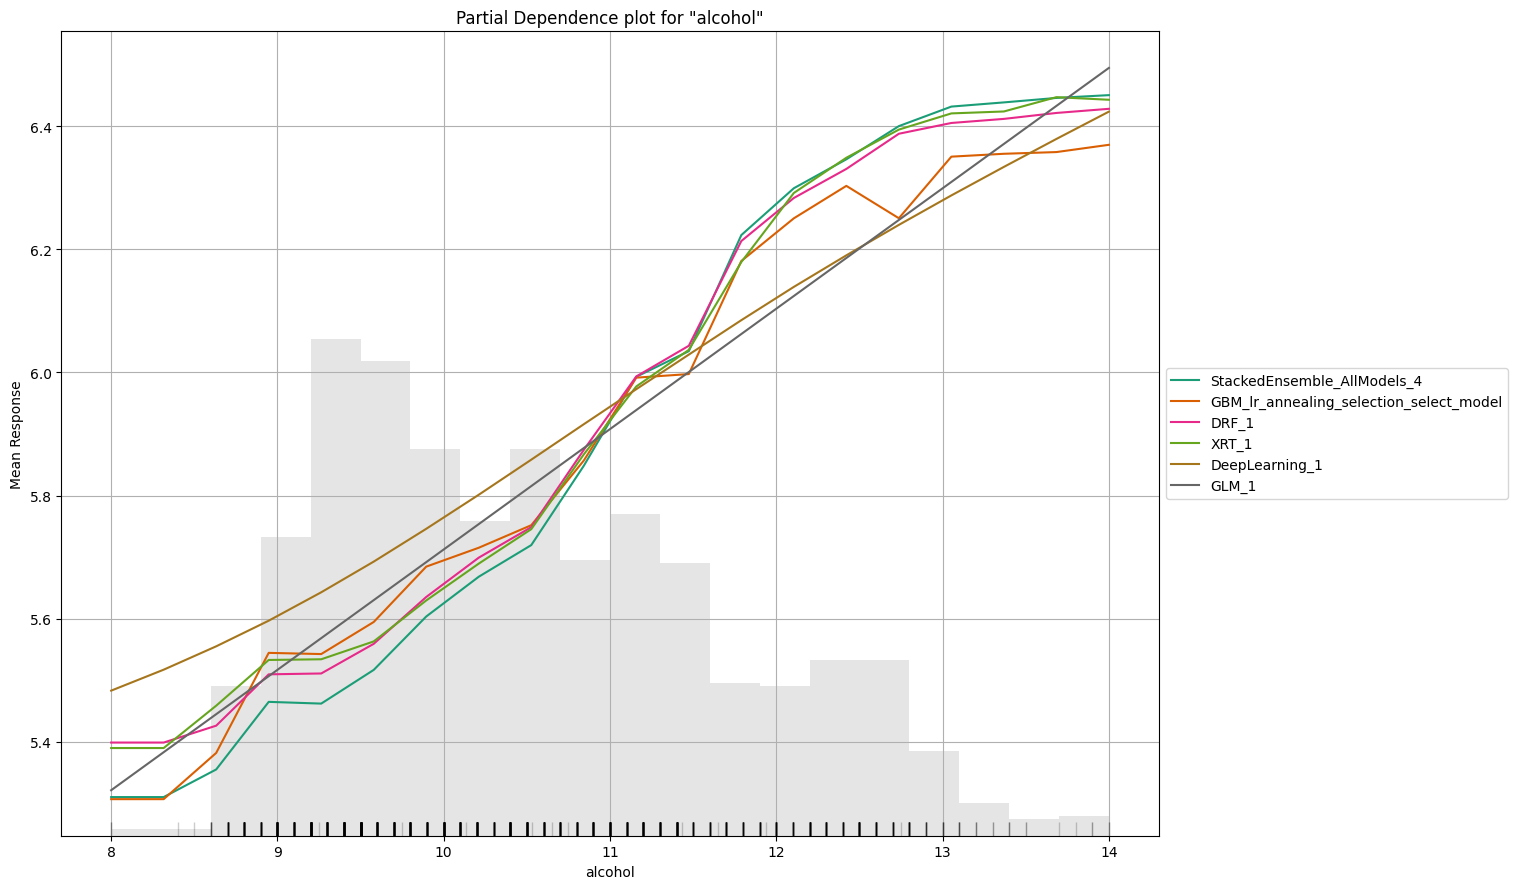

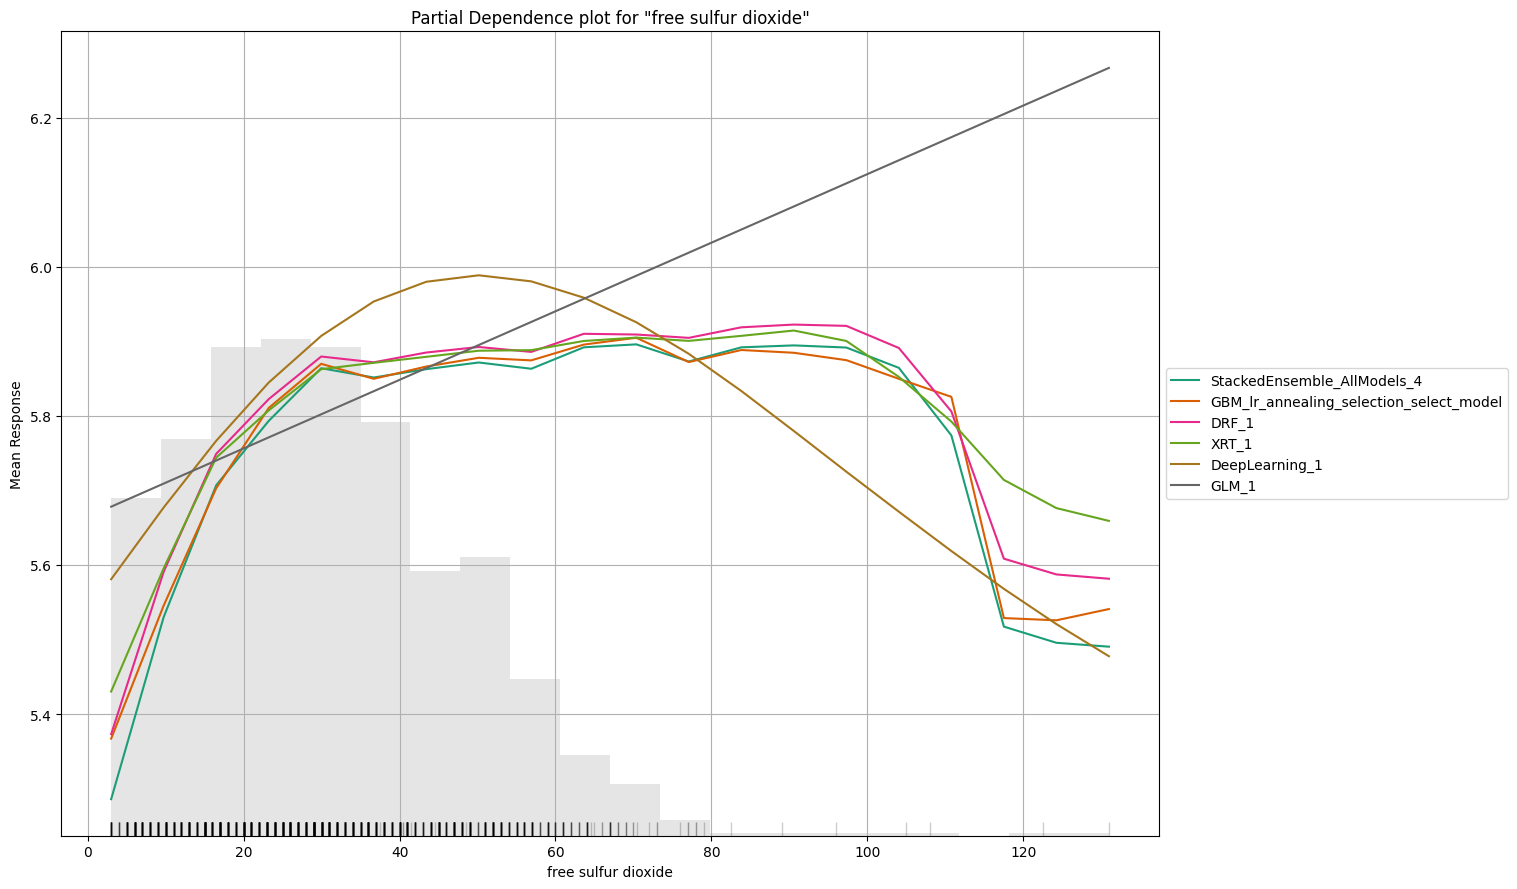

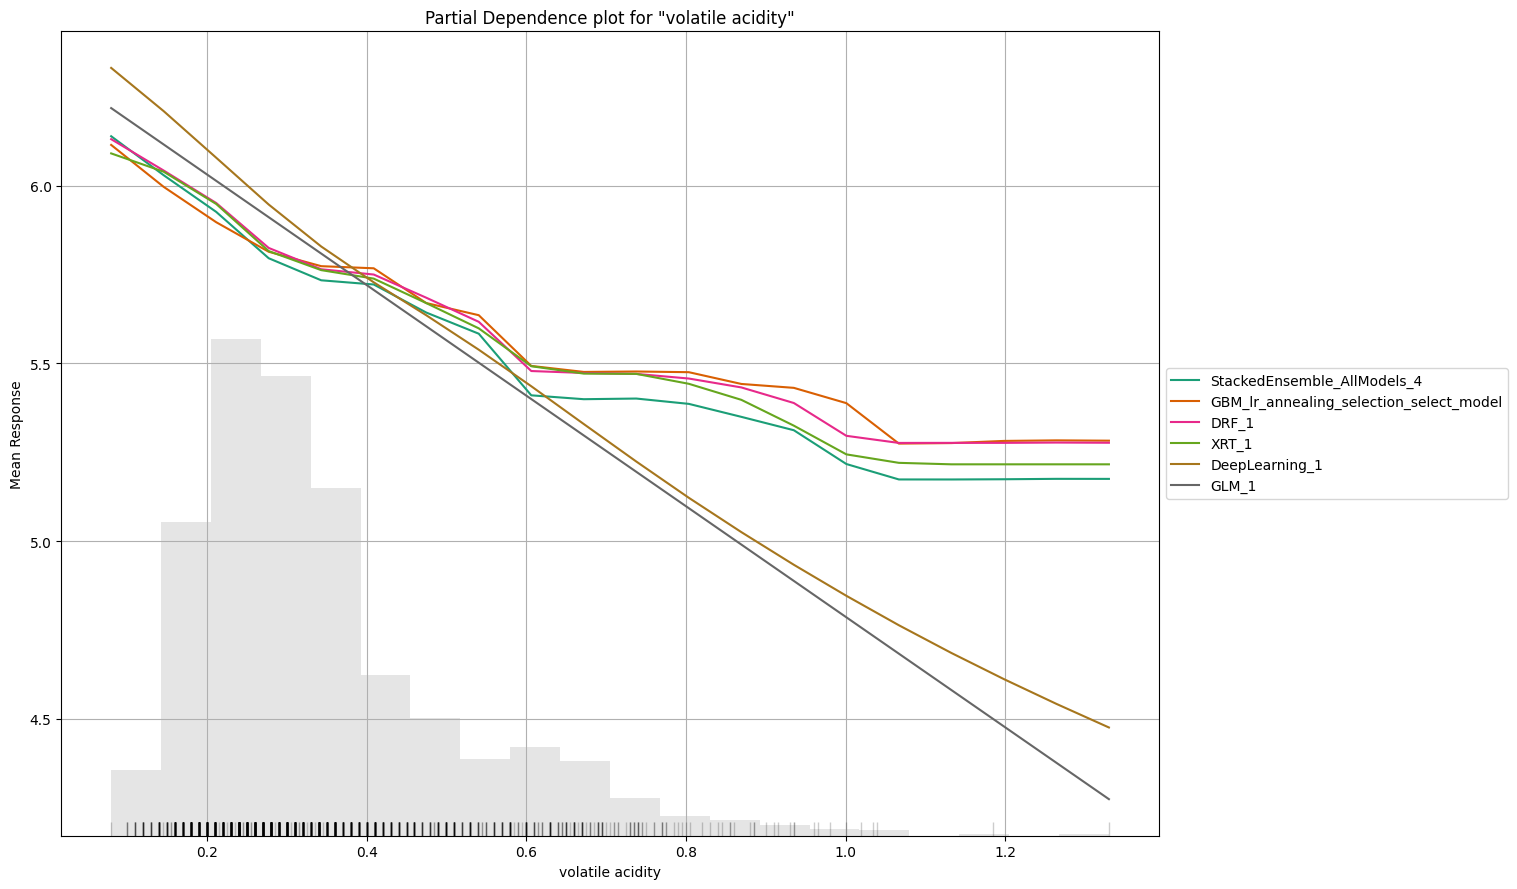

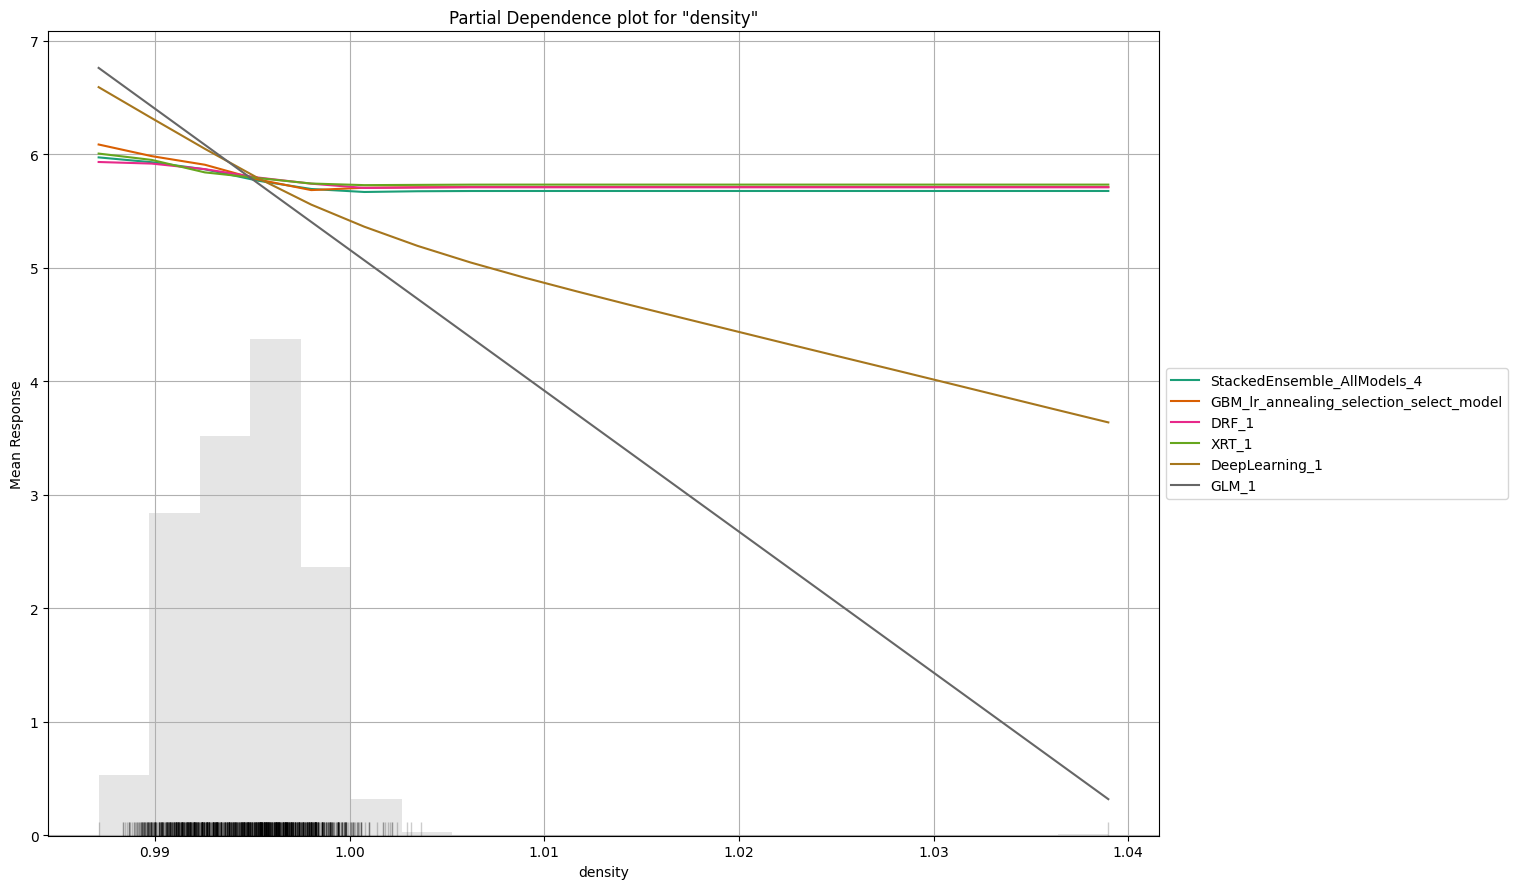

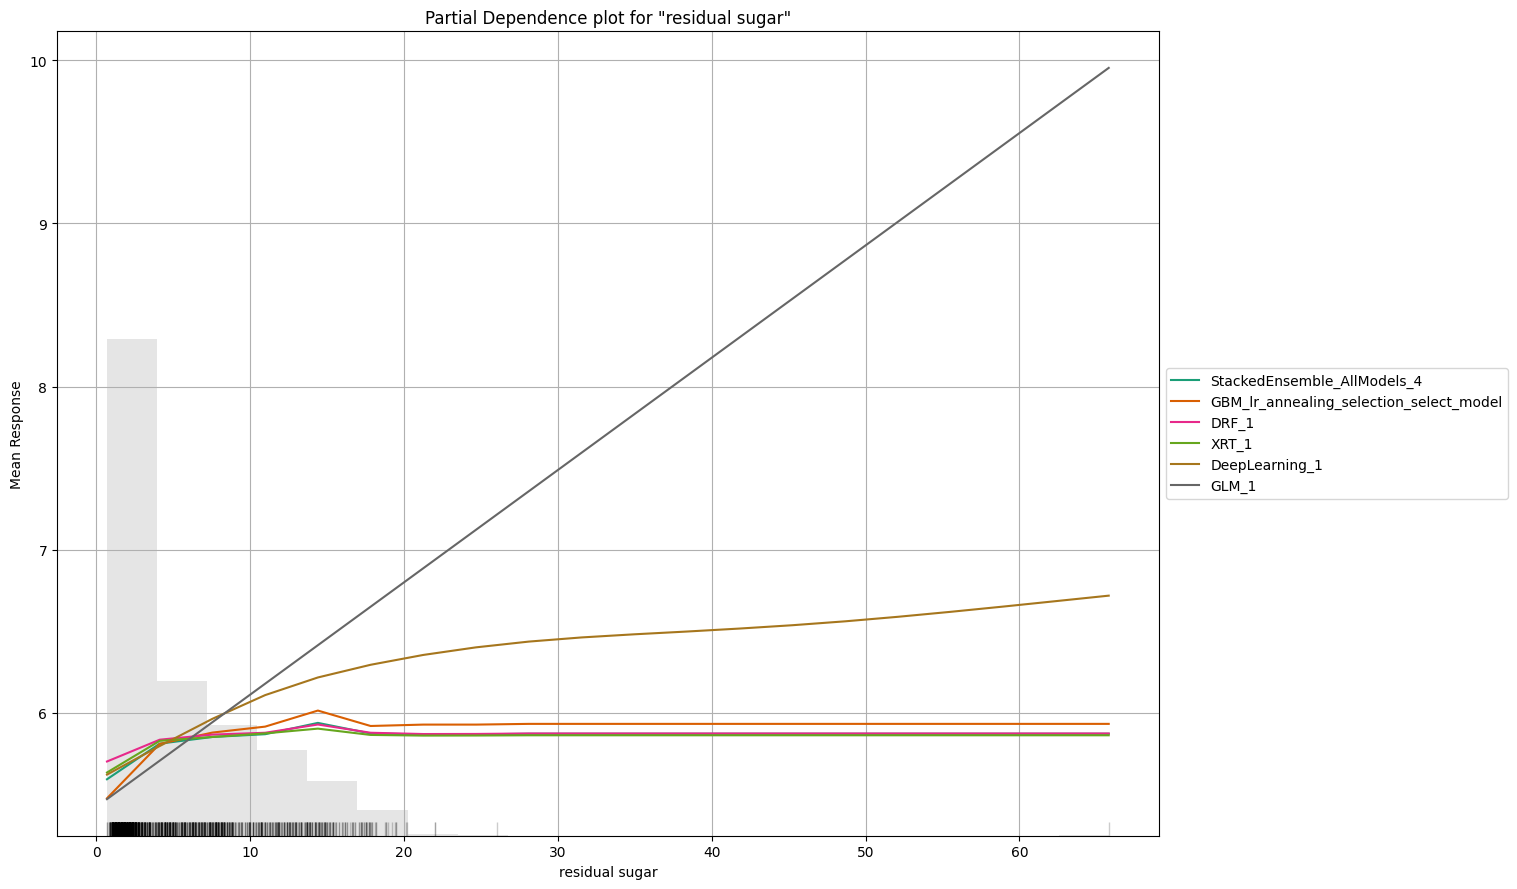

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

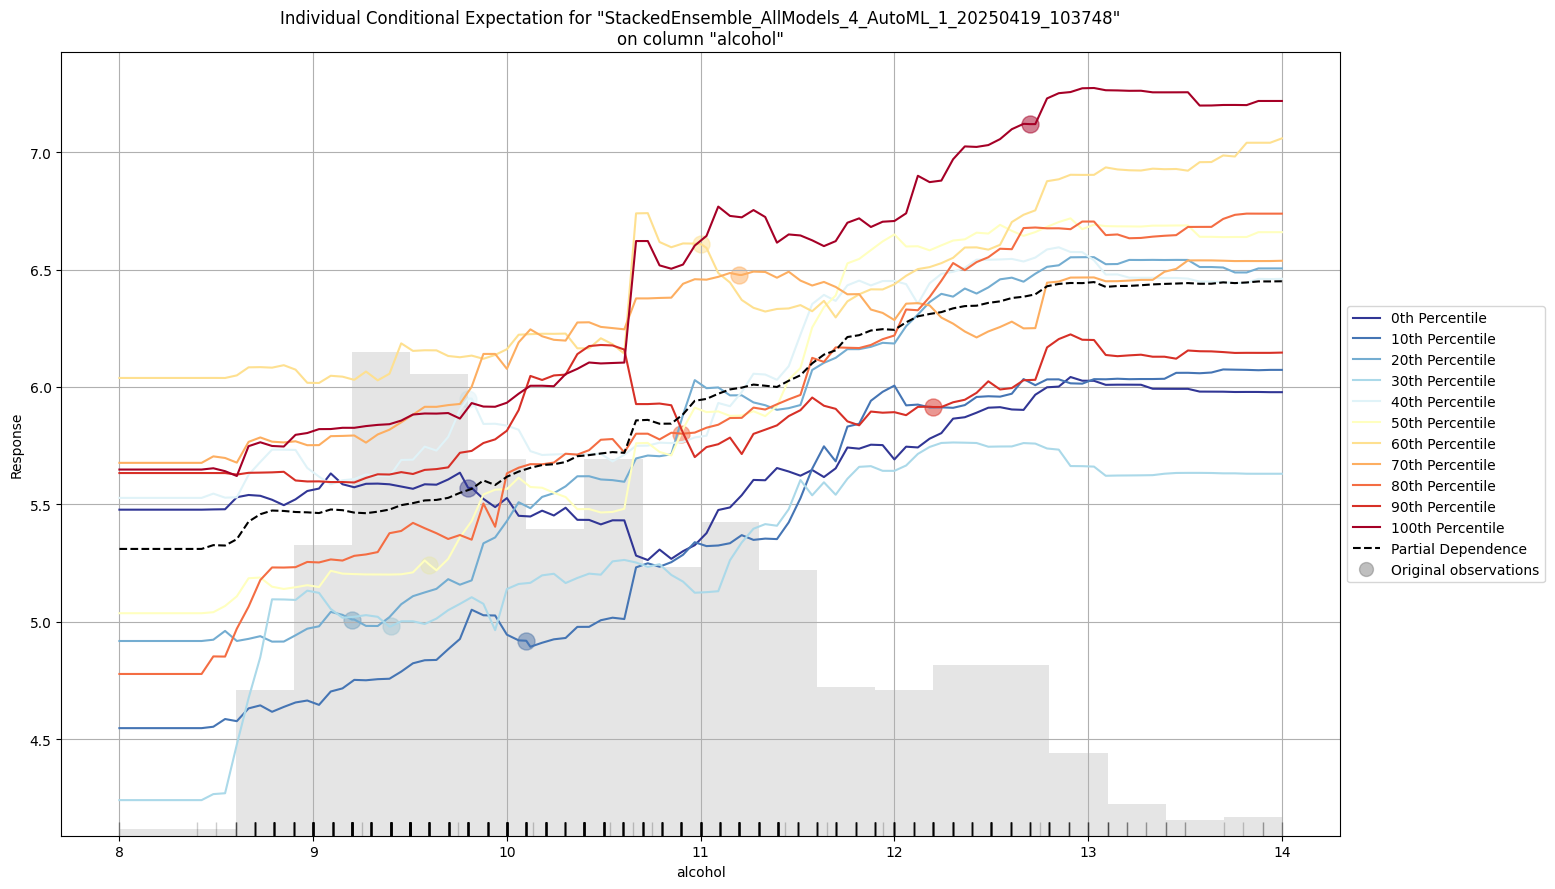

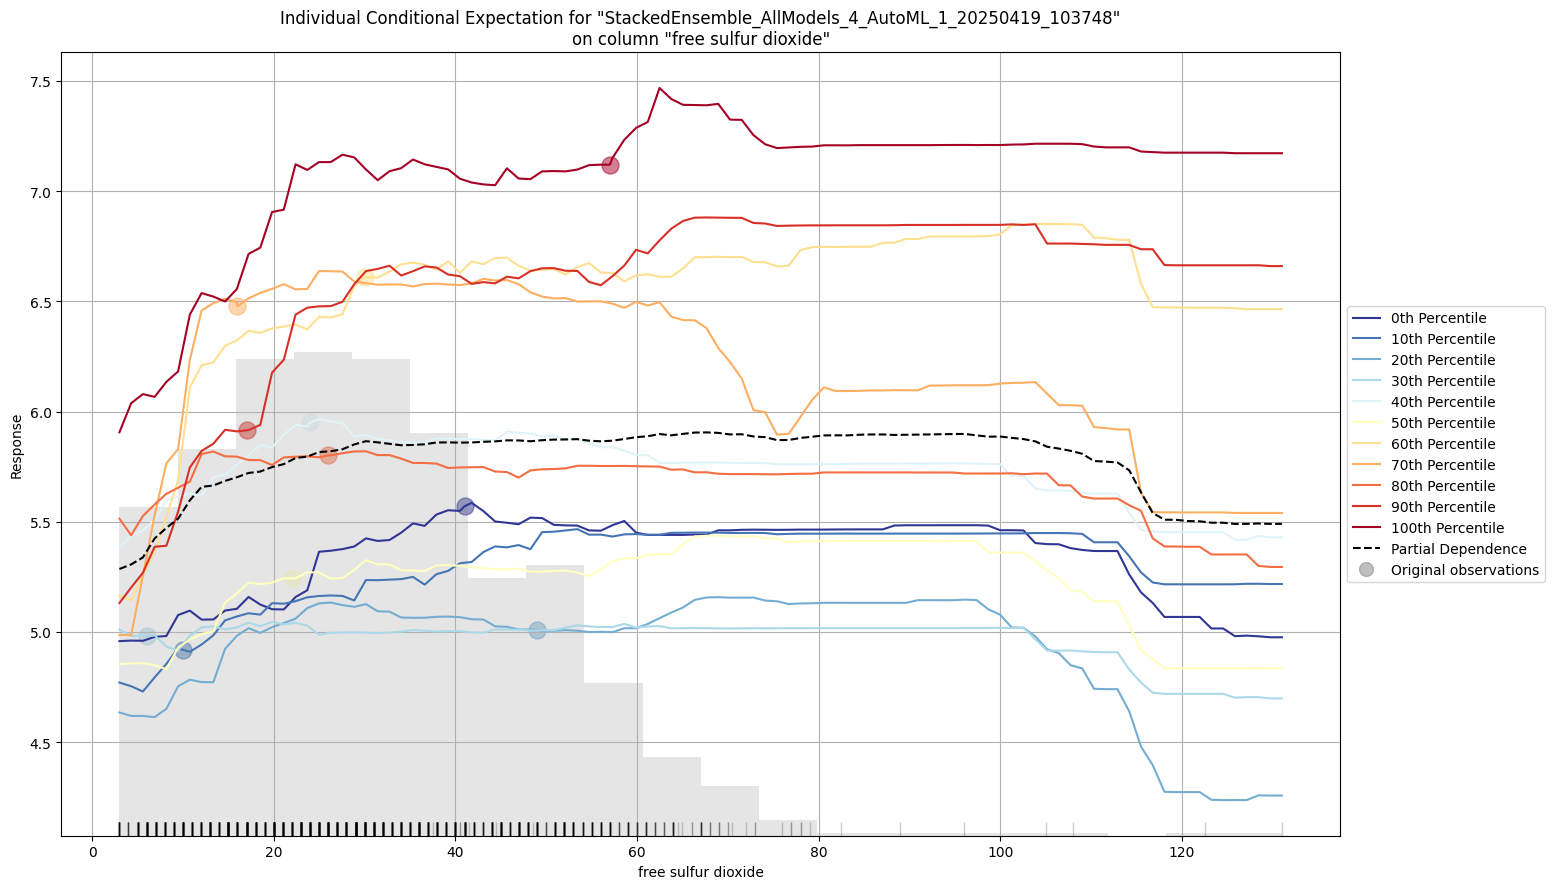

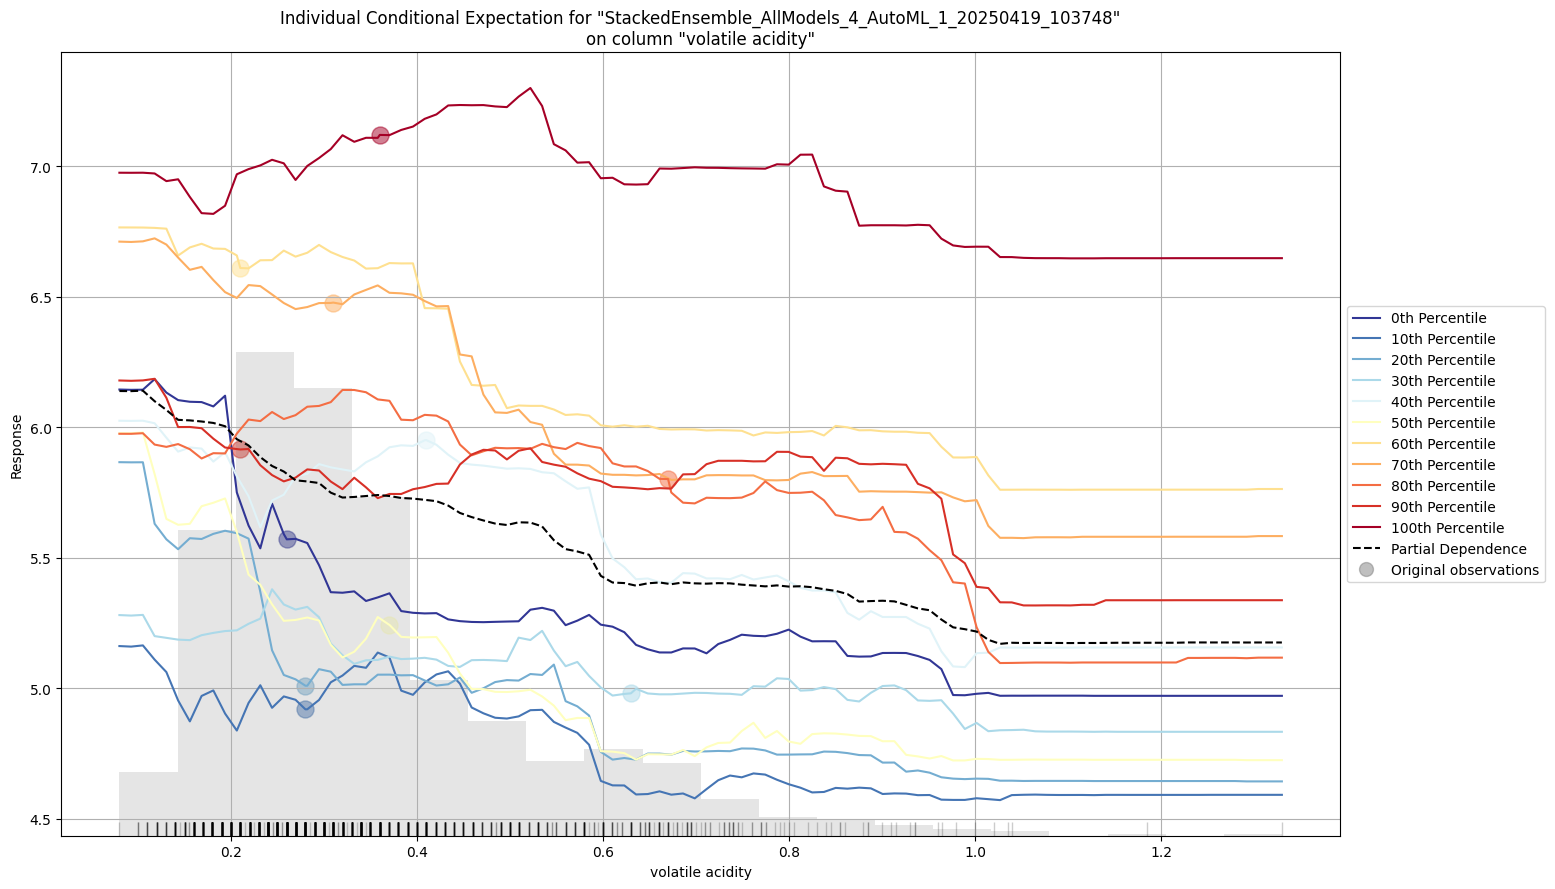

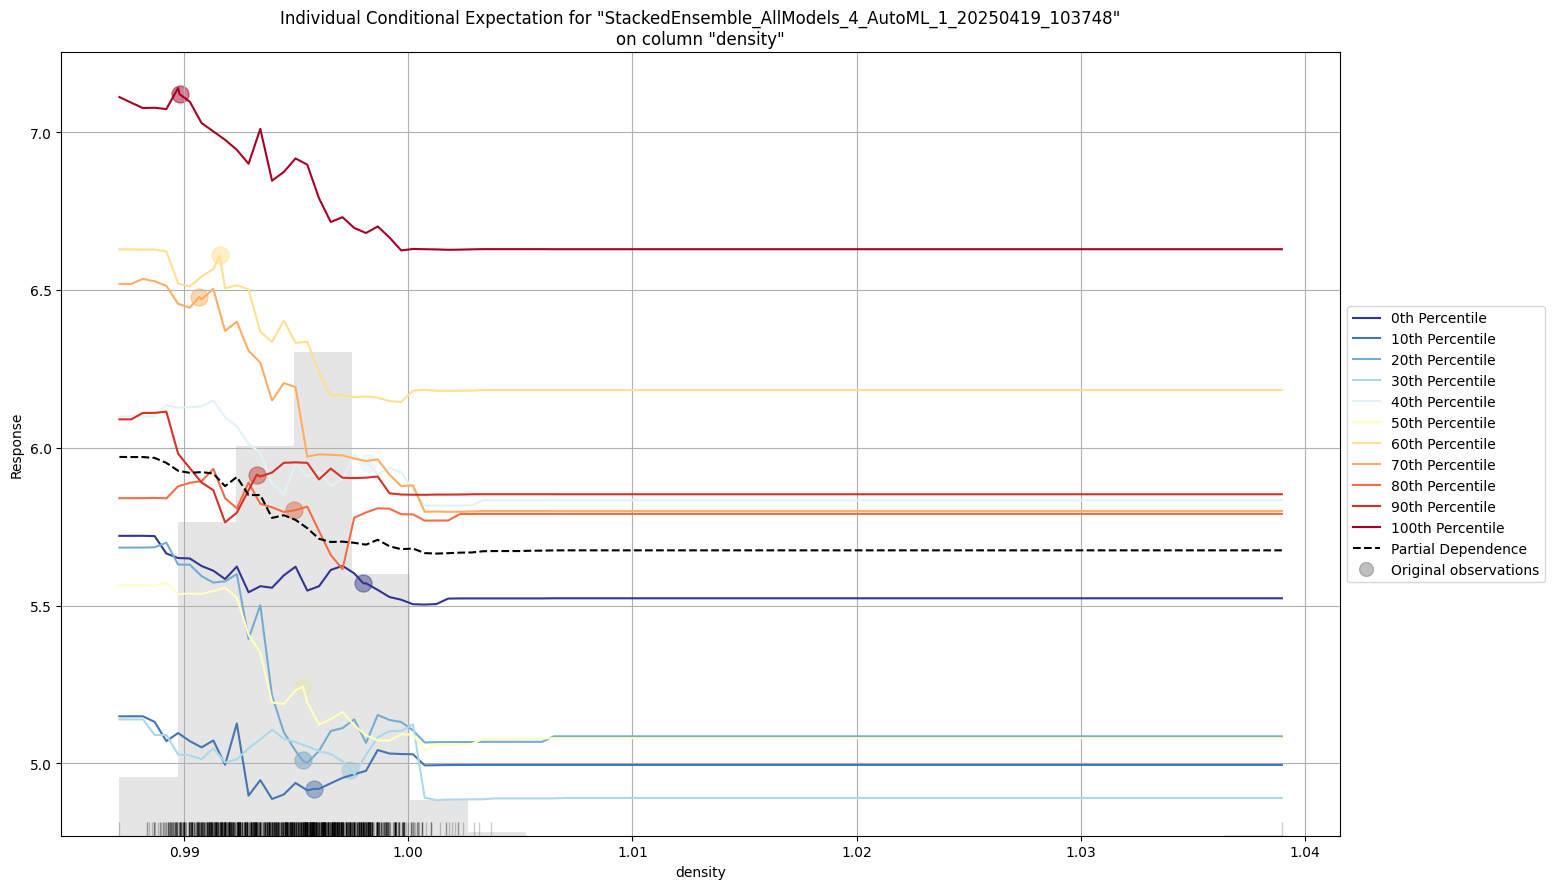

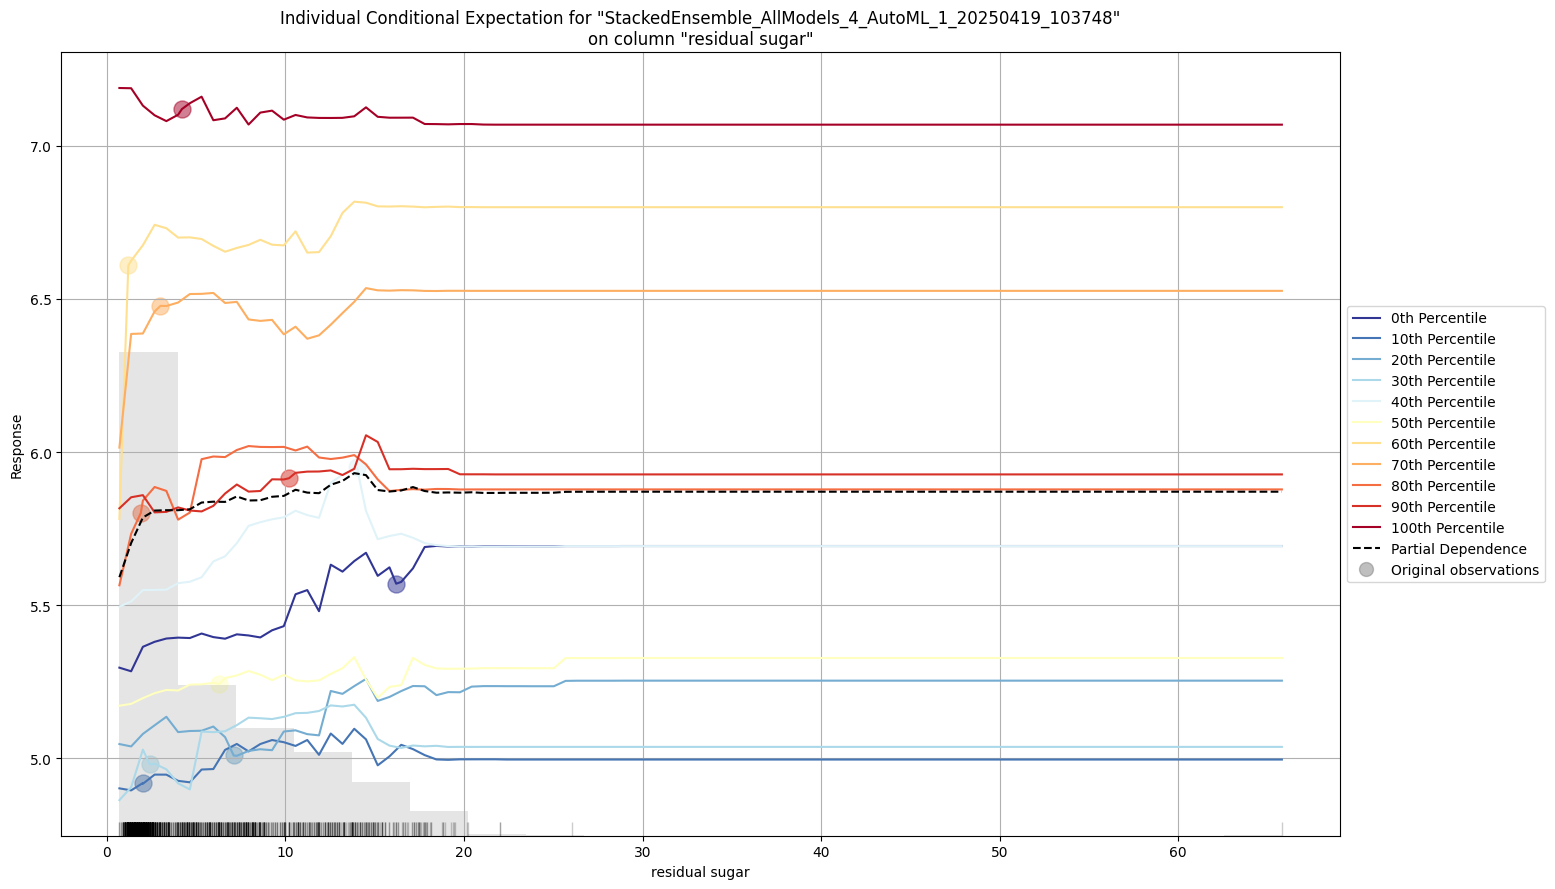

In [19]:
# AutoML 전체 결과 설명 (리더 모델 및 다른 모델 비교 포함)
print("--- H2O AutoML 전체 설명 ---")
expl_aml = aml.explain(test_h2o)
# expl_aml 객체를 출력하면 다양한 설명 플롯이 나타납니다. (변수 중요도, 모델 상관관계 등)
# print(expl_aml) # 주석 해제하여 결과 확인

#### 잔차 분석

>1. 패턴 존재: 이 그래프에서는 예측값(x축)이 증가함에 따라 잔차가 뚜렷한 직선 패턴을 보이고 있습니다. 이상적인 잔차 분포라면 무작위로 분포해야 하는데, 이런 패턴은 모델이 데이터의 특정 관계를 충분히 포착하지 못했음을 의미합니다.
>
>2. 줄무늬 형태: 그래프에서 보이는 명확한 줄무늬 패턴은 타겟 변수가 정수값이기 때문에 발생하는 현상입니다. 이는 문제라기보다는 정수형 응답 변수의 특성입니다.
이분산성: 예측값이 달라짐에 따라 잔차의 분산이 변하는 것으로 보이며, 특히 예측값이 중간 범위(5.0~6.5)에서 잔차의 분산이 더 큽니다. 이는 모델이 특정 범위에서 예측 정확도가 떨어질 수 있음을 시사합니다.
>
>3. 이상치: 몇몇 지점에서 +3, -3 이상의 큰 잔차를 보이는 이상치가 있으며, 이는 모델이 특정 데이터 포인트를 잘 예측하지 못함을 나타냅니다.
>
>결론적으로, 이 모델은 전반적으로 좋은 성능을 보이지만 데이터의 일부 패턴을 놓치고 있으며, 비선형성이나 추가 변수 고려를 통해 개선할 여지가 있습니다.

#### Learning Curve 분석
> 1. 단일 데이터 포인트: 그래프에는 단 하나의 트레이닝 포인트만 표시되어 있습니다. 이는 스택 앙상블 메타러너의 특성을 반영합니다. 이 모델은 기본 모델들의 예측을 조합하는 메타모델로, 일반적으로 한 번의 학습만 수행합니다.
> 
> 2. 편차(deviance) 값: y축의 값은 약 0.37로, 이는 모델의 손실 함수 값을 나타냅니다. 이 값은 리더보드에서 본 MSE 값(0.369731)과 유사합니다.
> 
> 3. 선택된 반복(Selected iterations): 녹색 수직선이 iteration 1.0에 표시되어 있어 단 한 번의 학습으로 최종 모델이 선택되었음을 보여줍니다.
> 
> 4. 교차 검증 정보 부재: 그래프에는 교차 검증 결과가 표시되지 않아 과적합 여부를 직접적으로 판단하기 어렵습니다.
> 
> 이 그래프는 StackedEnsemble 모델의 특성상 기본 모델들의 예측을 메타모델이 한 번 학습하여 통합하는 과정을 보여주는 것으로, 일반적인 트리 기반 알고리즘의 반복적 학습 과정과는 다른 패턴을 보여줍니다. 모델의 성능 평가는 이 그래프보다 앞서 본 리더보드 결과를 통해 더 잘 파악할 수 있습니다.

#### 특정 모델 변수 중요도 분석
 
> 이 그래프는 "GBM_lr_annealing_selection" 모델에서 각 변수의 상대적 중요도를 보여줍니다.
>
> 1. 가장 중요한 변수:
>    - 알코올(alcohol)이 압도적으로 가장 높은 중요도(약 1.0)를 보이며, 모델의 예측에 가장 큰 영향을 미치고 있습니다.
>
> 2. 중간 수준의 중요도를 가진 변수들:
>    - 유리 이산화황(free sulfur dioxide): 중요도 약 0.48
>    - 휘발성 산도(volatile acidity): 중요도 약 0.46
>    - 밀도(density): 중요도 약 0.43
>    - 잔류 당(residual sugar): 중요도 약 0.41
>    - 총 이산화황(total sulfur dioxide): 중요도 약 0.39
>
> 3. 상대적으로 낮은 중요도를 가진 변수들:
>    - 황산염(sulphates): 중요도 약 0.33
>    - 염화물(chlorides): 중요도 약 0.30
>    - pH: 중요도 약 0.28
>    - 고정 산도(fixed acidity): 중요도 약 0.27
>
> 이러한 결과는 와인의 품질 예측에 있어서 알코올 함량이 가장 결정적인 요소임을 나타내며, 황 관련 성분과 산도도 중요한 요소임을 보여줍니다. 이 정보를 활용하여 모델 개선이나 와인 품질 관리에 집중할 변수를 결정할 수 있습니다.

#### 전체모델 변수 중요도 히트맵

> 이 히트맵은 여러 모델에서 각 변수의 중요도를 비교하여 보여주고 있습니다
>
> 1. 알코올(alcohol) 변수:
>    - 대부분의 모델에서 가장 높은 중요도(붉은색 계열)를 보이고 있음
>    - 특히 GBM_grid_1_model_13, GBM_lr_annealing_selection_model, XRT_1, DRF_1 모델에서 매우 높은 중요도를 나타냄
>    - 와인 품질 예측에 있어 가장 일관되게 중요한 변수임을 확인할 수 있음
>
> 2. 와인 유형(type) 변수:
>    - 모든 모델에서 일관되게 가장 낮은 중요도(짙은 파란색)를 보임
>    - 예측에 거의 영향을 미치지 않는 것으로 판단됨
>
> 3. 휘발성 산도(volatile acidity)와 밀도(density):
>    - 일부 모델에서 중간 수준의 중요도(연한 노란색)를 보임
>    - 모델에 따라 중요도의 변동이 있음
>
> 4. 기타 변수들:
>    - 염화물(chlorides), 황 관련 변수들, pH 등은 대부분의 모델에서 중간~낮은 중요도를 보임
>    - 모델마다 이러한 변수들의 중요도 평가가 다소 다른 것을 볼 수 있음
>
> 5. 모델 간 비교:
>    - GBM 계열 모델들 사이에서도 변수 중요도 평가에 차이가 있음
>    - 앙상블 모델(XRT_1, DRF_1)은 GBM 모델들과 유사한 패턴을 보이지만 일부 변수에 대해 다른 중요도 평가를 함
>
> 이 히트맵을 통해 다양한 모델에서 알코올 함량이 가장 중요한 예측 변수임을 확인할 수 있으며, 와인 품질 예측 시 이 변수에 특히 주목할 필요가 있음을 알 수 있습니다.

#### 모델 상관관계 히트맵

> 1. 전반적인 상관성
>    - 대부분의 모델 예측 결과가 높은 상관관계(0.8 이상, 붉은색 계열)를 보여주고 있어 다양한 모델들이 유사한 패턴으로 예측하고 있음을 알 수 있습니다.
>    - 대각선의 진한 붉은색은 각 모델이 자신과의 완벽한 상관관계(1.0)를 나타냅니다.
>
> 2. 모델 그룹별 특성
>    - GBM 계열 모델들(상단 왼쪽): 서로 간에 높은 상관관계를 보이지만, 다른 모델 유형과는 상대적으로 낮은 상관성을 보입니다.
>    - StackedEnsemble 모델들: 서로 간에 매우 높은 상관관계(0.9 이상)를 보이며, 특히 AllModels와 BestOfFamily 앙상블 간에도 예측 결과가 매우 유사합니다.
>    - XRT_1과 StackedEnsemble_BestOfFamily_5는 가장 높은 상관관계를 보이는 쌍 중 하나입니다.
>
> 3. 모델 차별성
>    - 히트맵에서 상관계수가 0.8 미만인 영역이 거의 없어, 대부분의 모델이 비슷한 방향으로 예측하고 있음을 나타냅니다.
>    - 가장 낮은 상관관계는 GBM_grid_1_model_13과 다른 모델들 사이에서 관찰됩니다(상대적으로 덜 붉은색).
>
> 4. 앙상블 모델의 특성
>    - 앙상블 모델들(StackedEnsemble)은 개별 기본 모델들과도 높은 상관관계를 보여, 다양한 모델의 예측을 효과적으로 통합하고 있음을 알 수 있습니다.
>    - 상위 성능을 보인 StackedEnsemble_AllModels_4는 다른 앙상블 모델들과 매우 유사한 예측 패턴을 보입니다.
>
> 이 히트맵은 모델 다양성 측면에서 현재 구축된 모델들이 서로 상당히 유사한 예측을 한다는 것을 보여주며, 더 다양한 접근법이나 다른 알고리즘을 도입하여 모델 앙상블의 다양성을 증가시킬 여지가 있음을 시사합니다.

#### SHAP 요약 플롯 분석

> 1. 특성 중요도 순위
>    - 알코올(alcohol): 가장 영향력이 큰 특성으로, 높은 알코올 함량(빨간색 점)은 대체로 양의 shap 값을 가져 와인 품질 점수를 높이는데 기여합니다.
>    - 휘발성 산도(volatile acidity): 두 번째로 중요한 특성으로, 높은 값(빨간색)은 주로 음의 shap 값과 연관되어 품질 점수를 낮추는 경향이 있습니다.
>    - 밀도(density): 세 번째로 중요한 특성으로, 높은 밀도(빨간색)는 품질 점수를 낮추는데 기여합니다.
>
> 2. 특성 영향 패턴
>    - 아황산염(free sulfur dioxide, total sulfur dioxide): 중간 정도의 영향력을 보이며, 높은 총 아황산염 함량은 품질에 부정적 영향을 미칩니다.
>    - 잔류 당분(residual sugar): 높은 값(빨간색)은 대체로 품질에 긍정적 영향을 미치지만, 영향력은 중간 정도입니다.
>    - pH: 높은 pH 값은 약간 더 높은 품질 점수와 연관되어 있습니다.
>
> 3. 특성 분포 특징
>    - 대부분의 특성은 0을 중심으로 대칭적인 분포를 보이지만, 알코올과 휘발성 산도는 더 넓은 영향 범위를 갖습니다.
>    - 타입(type): 가장 영향력이 적은 특성으로, 이진 변수로 보이며 두 가지 범주(아마도 레드/화이트 와인)의 구분이 품질 예측에 큰 차이를 만들지 않습니다.
>
> 4. 종합 해석
>    - 알코올 함량이 높을수록 와인 품질 점수가 높아지는 강한 경향이 있습니다.
>    - 휘발성 산도가 낮을수록 와인 품질이 향상됩니다.
>    - 밀도가 낮을수록 품질 점수가 좋아지는 경향이 있습니다.
>    - SHAP 값은 각 특성의 기여도를 정량화하여 모델의 예측 과정을 투명하게 보여주며, 이는 와인 품질 향상을 위한 특성 최적화에 중요한 정보를 제공합니다.

#### 알코올 함량에 대한 부분 의존성 플롯 분석
 
>1. 전반적인 경향성:
>   - 모든 모델에서 알코올 함량이 증가할수록 예측된 와인 품질(Mean Response)이 일관되게 증가합니다.
>   - 알코올 함량이 8%에서 14%로 증가함에 따라 예측 품질 점수는 약 5.3에서 6.4로 상승합니다.
>
>2. 비선형적 관계:
>   - 대부분의 모델은 알코올 함량과 품질 사이에 단순한 선형 관계가 아닌 비선형적 패턴을 보여줍니다.
>   - 특히 알코올 함량 11-12% 구간에서 품질 증가 속도가 더 가파르게 나타납니다.
>
>3. 모델별 차이점:
>   - GLM_1(회색): 가장 선형적인 관계를 보여주며, 일정한 기울기로 증가합니다.
>   - StackedEnsemble_AllModels_4(녹색): 낮은 알코올 함량에서는 보수적인 예측을, 높은 함량에서는 더 높은 품질을 예측합니다.
>   - DeepLearning_1(갈색): 낮은 알코올 함량에서 다른 모델보다 높은 품질 예측을 보입니다.
>   - GBM 모델(주황색): 중간 범위에서 약간의 변동성을 보여주며, 다른 모델들과 비교해 독특한 패턴을 보입니다.
>
>4. 데이터 분포:
>   - 하단의 회색 히스토그램은 데이터셋에서 알코올 함량의 분포를 나타냅니다.
>   - 대부분의 와인 샘플이 9-12% 사이의 알코올 함량을 가지고 있으며, 이 범위에서 모델들의 예측이 가장 신뢰할 만합니다.
>
>5. 임계점:
>   - 알코올 함량 11% 부근에서 대부분 모델의 기울기가 변화하는데, 이는 이 지점이 품질 평가에 중요한 임계값임을 시사합니다.
>
>이 부분 의존성 플롯은 다른 모든 특성들이 평균값을 유지한다고 가정했을 때, 알코올 함량만 변경하면 와인 품질 예측이 어떻게 변하는지를 보여줍니다. 모든 모델이 알코올 함량이 높아질수록 품질 예측이 향상된다는 일관된 패턴을 보여주지만, 그 관계는 완전히 선형적이지 않습니다. 와인 생산자들은 품질 향상을 위해 적절한 알코올 함량(특히 11% 이상)을 목표로 할 수 있으며, 이는 SHAP 플롯에서도 확인된 알코올 변수의 중요성을 다시 한번 입증합니다.

#### 유리 이산화황(free sulfur dioxide)에 대한 부분 의존성 플롯 분석

>1. 비선형적 관계:
>   - 알코올과 달리, 유리 이산화황은 대부분의 모델에서 명확한 역 U자형 패턴을 보여줍니다.
>   - 소량(0-20mg/L)에서는 농도 증가에 따라 예측 품질이 빠르게 상승합니다.
>   - 중간 농도(20-100mg/L)에서는 상대적으로 안정적인 품질 예측을 유지합니다.
>   - 높은 농도(100mg/L 이상)에서는 품질 예측이 급격히 하락합니다.
>
>2. 모델별 차이점:
>   - GLM_1(회색 선): 유일하게 선형적 관계를 보여주며, 농도가 증가할수록 품질 예측이 지속적으로 상승합니다.
>   - DeepLearning_1(갈색): 초기에 빠르게 상승하고 약 40mg/L에서 최고점에 도달한 후 다른 모델들보다 더 빠르게 하락합니다.
>   - StackedEnsemble_AllModels_4(녹색): 고농도에서도 상대적으로 완만한 하락을 보여줍니다.
>   - DRF_1(분홍색): 가장 넓은 최적 범위를 보여주며, 약 90mg/L까지 안정적인 품질 예측을 유지합니다.
>
>3. 최적 범위:
>   - 대부분의 모델이 약 20-40mg/L 사이에서 최고 품질 예측을 보여주며, 이는 와인 제조 시 이상적인 유리 이산화황 농도 범위로 볼 수 있습니다.
>   - 100mg/L 이상의 농도는 모든 비선형 모델에서 품질을 저하시키는 것으로 나타납니다.
>
>4. 데이터 분포:
>   - 회색 히스토그램은 데이터셋에서 유리 이산화황 농도 분포를 보여줍니다.
>   - 대부분의 샘플이 10-40mg/L 범위에 집중되어 있으며, 이 범위에서 모델들의 예측이 가장 신뢰할 만합니다.
>   - 60mg/L 이상의 데이터는 상대적으로 적어, 고농도에서의 예측은 신뢰도가 낮을 수 있습니다.
>
>5. 종합 해석:
>   - 이 부분 의존성 플롯은 와인의 품질에 있어 유리 이산화황이 최적점이 있는 비선형적 관계를 가짐을 보여줍니다.
>   - 너무 적은 농도는 와인의 산화와 미생물 오염에 취약하게 만들 수 있고, 너무 높은 농도는 향미에 부정적 영향을 미칠 수 있습니다.
>   - GLM과 같은 선형 모델은 이러한 복잡한 관계를 제대로 포착하지 못하는 반면, 앙상블 모델과 트리 기반 모델들은 더 정교하게 이 관계를 모델링함을 알 수 있습니다.
>   - 와인 제조자들은 약 20-40mg/L의 유리 이산화황 농도를 목표로 하면 품질 최적화에 도움이 될 것으로 예상됩니다.

In [ ]:
# # 최적 모델(Leader Model)에 대한 설명
# print("\\n--- H2O Leader Model 설명 ---")
# expl_leader = leader_model.explain(test_h2o)
# # print(expl_leader) # 주석 해제하여 결과 확인 (변수 중요도, 부분 의존성 플롯 등)

In [ ]:
# # 특정 데이터 포인트(행)에 대한 로컬 설명 (예: 테스트 데이터의 첫 번째 행)
# print("\\n--- H2O Leader Model 로컬 설명 (테스트 데이터 첫 번째 행) ---")
# row_index_to_explain = 0
# expl_row = leader_model.explain_row(test_h2o, row_index=row_index_to_explain)
# # print(expl_row) # 주석 해제하여 결과 확인 (SHAP 기여도, ICE 플롯 등)


#### XAI : LIME 라이브러리 활용

In [31]:
X_train_pd

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,white
2,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,white
4,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,white
...,...,...,...,...,...,...,...,...,...,...,...,...
5200,6.8,0.62,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,red
5201,6.2,0.60,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,red
5202,5.9,0.55,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,red
5203,6.3,0.51,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,red


In [ ]:
from sklearn.preprocessing import LabelEncoder

# 범주형 특성 찾기
categorical_features = [i for i, col in enumerate(X_train_pd.columns) if X_train_pd[col].dtype == 'object' or X_train_pd[col].dtype.name == 'category']

# 데이터 복사본 만들기
X_train_numeric = X_train_pd.copy()
X_test_numeric = X_test_pd.copy()

# 범주형 변수에 레이블 인코딩 적용
label_encoders = {}
for i in categorical_features:
    col = X_train_pd.columns[i]
    le = LabelEncoder()
    X_train_numeric[col] = le.fit_transform(X_train_pd[col])
    X_test_numeric[col] = le.transform(X_test_pd[col])
    label_encoders[i] = le

# 인스턴스 선택 (테스트 데이터의 한 행)
instance_index_lime = 0  # 첫 번째 테스트 인스턴스 사용
instance_lime = X_test_numeric.iloc[instance_index_lime].values

# LIME 설명자 생성
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_numeric.values,
    feature_names=X_train_numeric.columns.tolist(),
    class_names=['low_quality', 'high_quality'],
    categorical_features=categorical_features,
    mode='regression' if leader_model.algo not in ["gbm", "drf", "xgboost", "deeplearning"] or leader_model.params['distribution']['value'] in ['gaussian', 'poisson', 'gamma', 'tweedie'] else 'classification'
)

# H2O 모델 예측 함수 래퍼
def h2o_predict_proba_wrapper_lime(X):
    # 데이터 프레임으로 변환
    X_df = pd.DataFrame(X, columns=X_train_numeric.columns)
    
    # 레이블 인코딩 값을 원래 범주형 값으로 다시 변환
    X_original = X_df.copy()
    for i in categorical_features:
        col = X_train_numeric.columns[i]
        X_original[col] = label_encoders[i].inverse_transform(X_df[col].astype(int))
    
    # H2O 프레임으로 변환
    X_h2o = h2o.H2OFrame(X_original)
    
    # 예측 수행
    preds = leader_model.predict(X_h2o).as_data_frame()
    
    # 분류 문제인 경우 확률 반환, 회귀 문제인 경우 예측값 반환
    if leader_model.algo in ["gbm", "drf", "xgboost", "deeplearning"] and leader_model.params['distribution']['value'] not in ['gaussian', 'poisson', 'gamma', 'tweedie']:
        if 'p0' in preds.columns:  # 이진 분류
            return preds[['p0', 'p1']].values
        else:  # 회귀
            return preds['predict'].values.reshape(-1, 1)
    else:  # 회귀
        return preds['predict'].values.reshape(-1, 1)

# 설명 생성
num_features_lime = 5  # 설명에 사용할 특성 수
explanation_lime = explainer_lime.explain_instance(
    data_row=instance_lime,
    predict_fn=h2o_predict_proba_wrapper_lime,
    num_features=num_features_lime
)

print(f"\nLIME Explanation (테스트 데이터 인덱스 {instance_index_lime}):")

# show_in_notebook 대신 텍스트 형태로 결과 출력
print("\nLIME 결과 (특성 중요도):")
for feature, importance in explanation_lime.as_list():
    print(f"{feature}: {importance:.4f}")

# 원래 특성 값과 예측 결과 출력
print("\n원본 인스턴스 정보:")
for i, col in enumerate(X_train_pd.columns):
    original_value = X_test_pd.iloc[instance_index_lime][col]
    print(f"{col}: {original_value}")

# 예측 결과 출력
instance_h2o = h2o.H2OFrame(X_test_pd.iloc[[instance_index_lime]])
prediction = leader_model.predict(instance_h2o).as_data_frame()
print("\n예측 결과:")
print(prediction)

# 분류 문제인 경우 예측 확률 출력
if leader_model.algo in ["gbm", "drf", "xgboost", "deeplearning"] and leader_model.params['distribution']['value'] not in ['gaussian', 'poisson', 'gamma', 'tweedie']:
    if 'p0' in prediction.columns:
        print(f"Class 0 (low_quality) 확률: {prediction['p0'].values[0]:.4f}")
        print(f"Class 1 (high_quality) 확률: {prediction['p1'].values[0]:.4f}")